# Anomaly Analysis

## 1. Import Libraries

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 2. Loading Data

In [74]:
data = pd.read_csv('../data/Transactions/transactions_1.csv')

print(data.head())

     time    status  f0_
0  00h 00  approved    9
1  00h 00    denied    6
2  00h 00  refunded    1
3  00h 01    denied    8
4  00h 01  approved   13


## 3. Data Preprocessing

In [75]:
# Convert the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'], format='%Hh %M')

data

,time,status,f0_
0,1900-01-01 00:00:00,approved,9
1,1900-01-01 00:00:00,denied,6
2,1900-01-01 00:00:00,refunded,1
3,1900-01-01 00:01:00,denied,8
4,1900-01-01 00:01:00,approved,13
...,...,...,...
4229,1900-01-01 23:59:00,processing,4
4230,1900-01-01 23:59:00,denied,1
4231,1900-01-01 23:59:00,backend_reversed,5
4232,1900-01-01 23:59:00,approved,10


## 4. Data Exploration

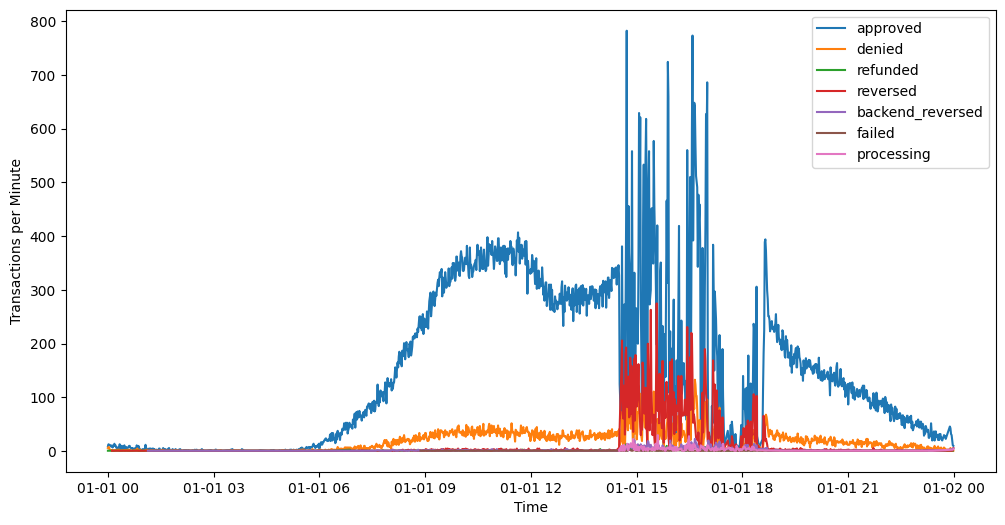

In [76]:
# View transaction graph per minute for each status
plt.figure(figsize=(12, 6))
for status in data['status'].unique():
    plt.plot(data[data['status'] == status]['time'], data[data['status'] == status]['f0_'], label=status)

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

Let's zoom in on the part that clearly has an anomaly

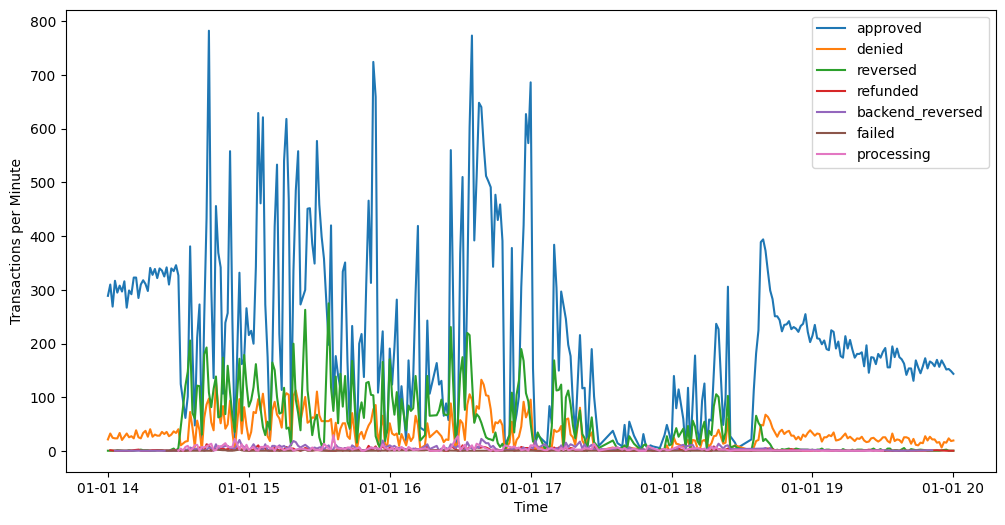

In [77]:
# Zoomed data
filtered_data = data[(data['time'] >= '1900-01-01 14:00:00') & (data['time'] <= '1900-01-01 20:00:00')]

plt.figure(figsize=(12, 6))
for status in filtered_data['status'].unique():
    plt.plot(filtered_data[filtered_data['status'] == status]['time'], filtered_data[filtered_data['status'] == status]['f0_'], label=status)

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

Let's evaluate the proportion for approved and other status

In [78]:
# Criação de um novo DataFrame organizado
pivoted_data = data.pivot_table(index='time', columns='status', values='f0_', fill_value=0).reset_index()

pivoted_data

status,time,approved,backend_reversed,denied,failed,processing,refunded,reversed
0,1900-01-01 00:00:00,9,0,6,0,0,1,0
1,1900-01-01 00:01:00,13,0,8,0,0,0,0
2,1900-01-01 00:02:00,11,0,7,0,0,1,0
3,1900-01-01 00:03:00,12,0,3,0,0,0,0
4,1900-01-01 00:04:00,11,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1317,1900-01-01 23:55:00,32,0,4,0,0,0,0
1318,1900-01-01 23:56:00,30,0,3,0,0,0,0
1319,1900-01-01 23:57:00,21,0,4,0,0,0,1
1320,1900-01-01 23:58:00,11,4,3,0,3,1,2


In [86]:
filtered_data = pivoted_data[(pivoted_data['time'] >= '1900-01-01 00:00:00') & (pivoted_data['time'] <= '1900-01-01 23:59:00')]


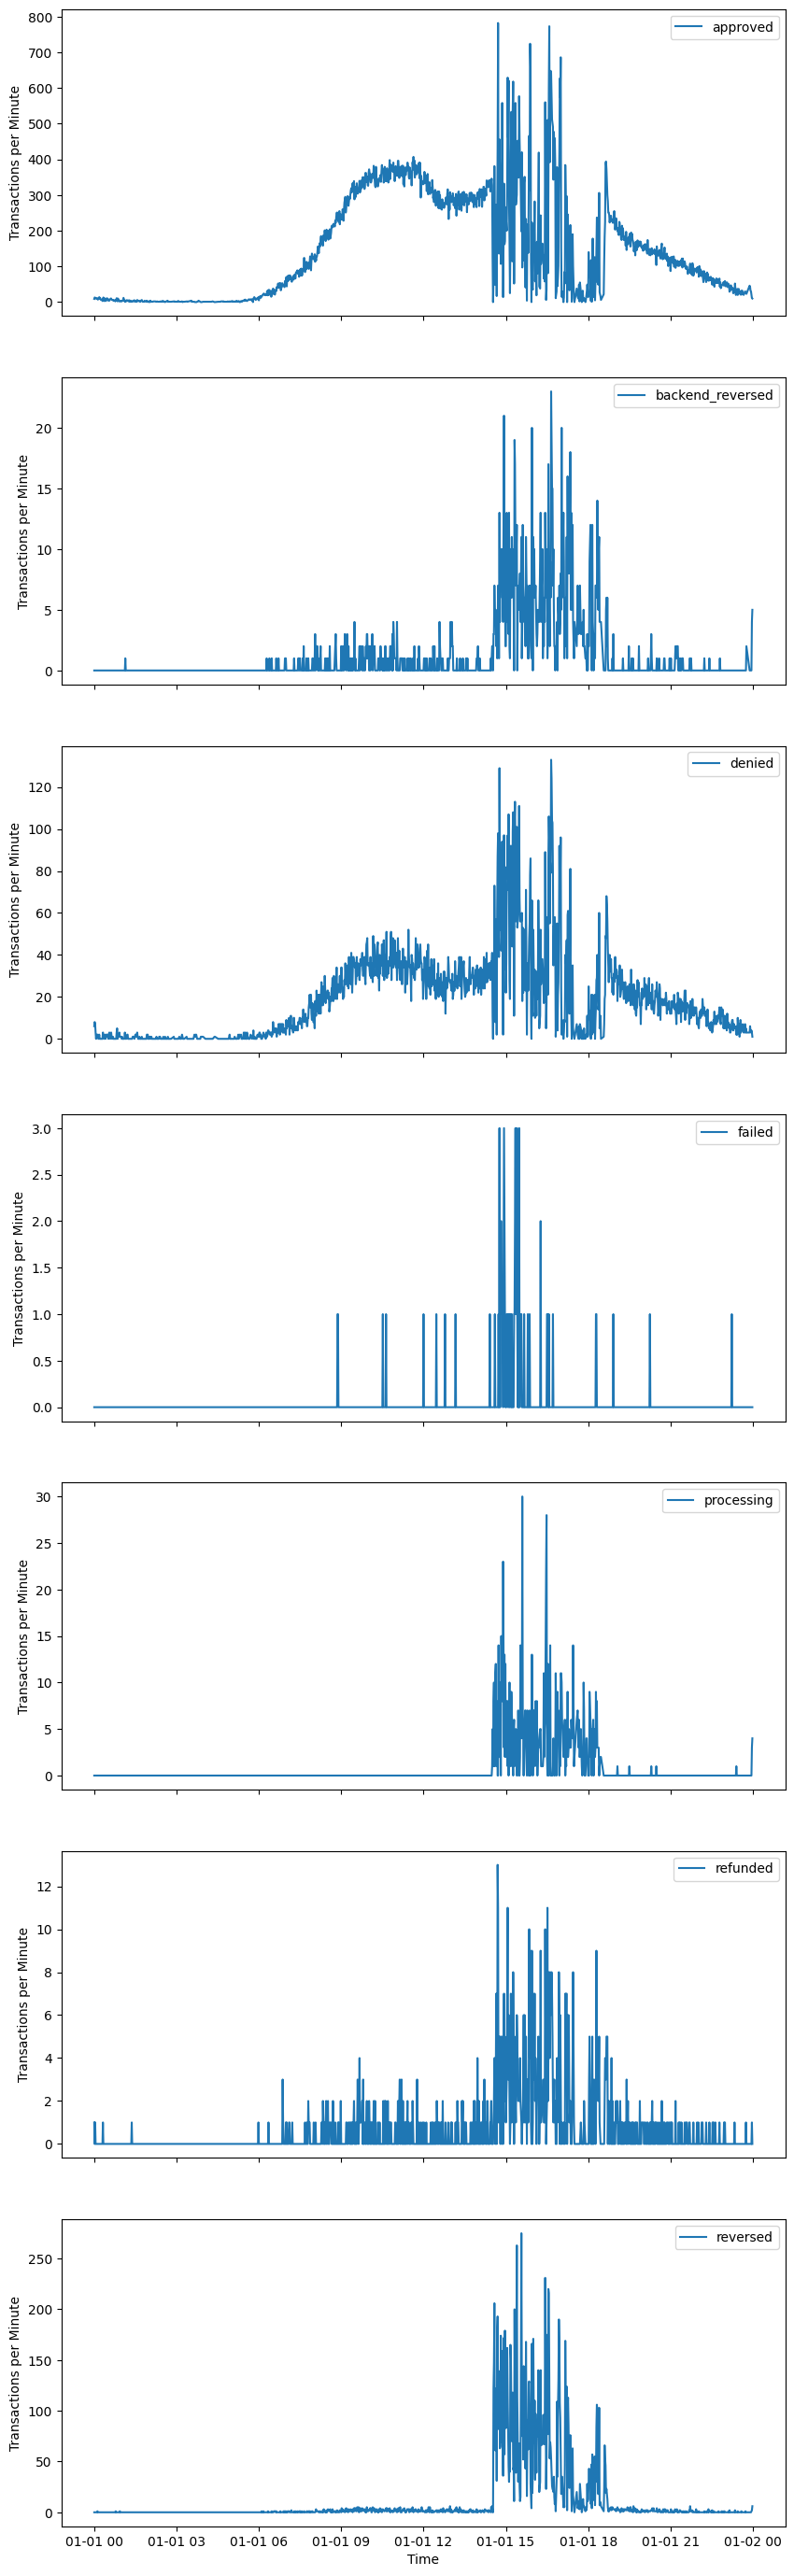

In [87]:
# Gráficos separados para cada status
statuses = filtered_data.columns[1:]

fig, axs = plt.subplots(len(statuses), 1, figsize=(10, 5 * len(statuses)), sharex=True)

for i, status in enumerate(statuses):
    axs[i].plot(filtered_data['time'], filtered_data[status], label=status)
    axs[i].set_ylabel('Transactions per Minute')
    axs[i].legend()

plt.xlabel('Time')
plt.show()

## 5. Conclusions

We can see that when the crash occurred, the indicator that represented well was the reversed one. As long as its value was above 10 for 3 minutes the anomaly was occurring. We can use this as a trigger for anomalies.

The denied indicator appears to grow along with approved transactions. Therefore, it is not a good numerical indicator for alerts. Let's try using a machine learning algo to detect anomalies from denied indicator.

The failed indicator seems to be common to appear at least 1 during the day, however when the failed indicator exceeds 1 it raises suspicion of an anomaly.